In [170]:
# Import packages
import os
import numpy as np
import pandas as pd
from scipy.stats import tvar, skew, kurtosis, zscore
from scipy.integrate import simps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn import svm

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from utils.dataloaders import OneSignal
from utils import random_state
# import random

import matplotlib.pyplot as plt
import seaborn as sns

random_state(36)

In [163]:
#---------------------------------------------------
#               Get features dataframe
#---------------------------------------------------

def merge_csv_files(folder_path):
    # Get a list of all CSV files in the specified folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Initialize an empty list to store individual DataFrames
    dfs = []

    # Loop through each CSV file and append its DataFrame to the list
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df

# Load the csv file containing the features
current_directory = os.path.dirname(os.path.abspath('__file__'))
folder_name = 'dataset/ML_features/'
folder_path = os.path.join(current_directory, folder_name)

df = merge_csv_files(folder_path)

In [164]:
# def fit_preprocess(train_full_features, features_selected):
#   feature_list = train_full_features.columns

#   # ----------1. OUTLIER REMOVAL----------------
#   # apply zscore
#   scaler_outliers = StandardScaler().fit(train_full_features)
#   zscore_features = scaler_outliers.transform(train_full_features)

#   # select all those values with zscore > -+ 3  as outliers
#   abs_zscores = np.abs(zscore_features)
#   outliers_detected = abs_zscores > 3
#   print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

#   # set outliers as missing values
#   train_full_features[outliers_detected] = np.nan
#   train_full_features =  pd.DataFrame(data=train_full_features, columns=feature_list)
#   print('Missing values after outlier removal (train): ' + str(train_full_features.isnull().sum().sum()))

#   # ----------2. MISSING VALUES IMPUTATION..........
#   # remove patients in training set with high percentage of missing data (TRAINING)
#   n_patiens_before = np.shape(train_full_features)[0]
#   train_full_features = train_full_features.dropna(thresh=np.shape(train_full_features)[1]/3)
#   n_patiens_after = np.shape(train_full_features)[0]
#   print('Number of patients dropped: ' + str(n_patiens_before-n_patiens_after))

#   imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
#   # fit on the dataset
#   imputer.fit(train_full_features)

#   train_full_features = imputer.transform(train_full_features)
#   train_full_features =  pd.DataFrame(data=train_full_features, columns=feature_list)

#   # ---------------3. FEATURE SCALING ---------------
#   transformer = StandardScaler().fit(train_full_features)
#   train_full_features = transformer.transform(train_full_features)
#   train_full_features = pd.DataFrame(data=train_full_features, columns=feature_list)

#   #----------------4. FEATURE SELECTION-----------------
#   train_full_features = train_full_features[features_selected]


#   feature_preprocessing = {'outlier_removal_scaler': scaler_outliers,
#                           'KNN_imputer': imputer,
#                           'scaler': transformer,
#                           'features_selected': features_selected}
#   return  feature_preprocessing

# def feature_preprocess(test_features, feature_preprocessing):
#   # test set preprocessing
#   feature_list = test_features.columns

#   # outlier removal
#   zscore_features = feature_preprocessing['outlier_removal_scaler'].transform(test_features)
#   outliers_detected = np.abs(zscore_features) > 3
#   print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))

#   test_features[outliers_detected] = np.nan
#   test_features =  pd.DataFrame(data=test_features, columns=feature_list)
#   print('Missing values after outlier removal (validation): ' + str(test_features.isnull().sum().sum()))

#   # missing data imputation
#   test_features = feature_preprocessing['KNN_imputer'].transform(test_features)
#   test_features =  pd.DataFrame(data=test_features, columns=feature_list)

#   # feature preprocessing
#   test_features = feature_preprocessing['scaler'].transform(test_features)
#   test_features = pd.DataFrame(data=test_features, columns=feature_list)

#   # feature selection
#   test_features = test_features[features_selected]

#   return  test_features

# # Training set creation and preprocessing
# train_full_labels = train_full.label
# train_full_features = train_full.drop(columns='label')
# features_selected = train_features.columns

# # Training set
# feature_preprocessing = fit_preprocess(train_full_features, features_selected)
# # Test set
# test_features = feature_preprocess(test_features, feature_preprocessing)

def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return

def plot_outliersAnalysis(abs_zscores, feature_list):
  # # number of outliers per subject
  # bool_zscores = (abs_zscores > 3).sum(axis=1)
  # bool_zscores.hist()
  # plt.title("Number of outliers per subject")
  # plt.show()

  # number of outliers per feature
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list, rotation=90)
  plt.show()
  return

# def plot_PCAanalysis(train_features_pca, pc_plot):
#   principalComponents_Df = pd.DataFrame(data = train_features_pca[:,pc_plot],
#                                       columns = ['principal component 1', 'principal component 2'])
#   plt.figure()
#   plt.figure(figsize=(10,10))
#   plt.xticks(fontsize=12)
#   plt.yticks(fontsize=14)
#   plt.xlabel('Principal Component - 1',fontsize=20)
#   plt.ylabel('Principal Component - 2',fontsize=20)
#   plt.title("Principal Component Analysis",fontsize=20)
#   targets = [0, 1]
#   colors = ['r', 'g']
#   for target, color in zip(targets,colors):
#     indicesToKeep = np.array(train_labels) == target
#     plt.scatter(principalComponents_Df.loc[indicesToKeep, 'principal component 1']
#                 , principalComponents_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

#   plt.legend(targets,prop={'size': 15})
#   return

def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  n_features = len(rfecv.cv_results_['mean_test_score'])
  plt.plot(range(min_features_to_select, min_features_to_select + n_features), rfecv.cv_results_['mean_test_score'])
  plt.show()

def plot_confusionMatrix(test_labels, test_predicted, clf):
  cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['NSR', 'AF'])
  disp.plot()
  plt.show()
  return

def testModel(train_features, train_labels, test_features, test_labels):
  clf = svm.SVC(C=1.0,
              kernel='rbf', # linear ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
              degree=6,
              gamma='scale',
              coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=200,
              class_weight=None,
              verbose=False,
              max_iter=- 1,
              decision_function_shape='ovr',
              break_ties=False)


  clf.fit(train_features, train_labels)

  # d. Predit test labels
  test_predicted = clf.predict(test_features)

  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)

  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=['NSR', 'AF']))

def testModel_2(train_features, train_labels, test_features, test_labels, clf):
  clf.fit(train_features, train_labels)

  # d. Predit test labels
  test_predicted = clf.predict(test_features)

  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)

  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=['NSR', 'AF']))

In [167]:
#---------------------------------------------------
#           Construct train/val/test split
#---------------------------------------------------

# Construct patient numbers
patient_numbers = [i for i in range(1, 122) if i not in [107, 120]+list(range(63, 79))]
# Set random state: reproducibility
random_state(36)

# Split the data into training (70%), validation (15%) and test (15%) sets
train_numbers, non_train_numbers = train_test_split(patient_numbers, test_size=0.3, random_state=36)
val_numbers, test_numbers = train_test_split(non_train_numbers, test_size=0.5, random_state=36)

# Print the lengths of the sets
print(f"Training set size: {len(train_numbers)}")
print(f"Validation set size: {len(val_numbers)}")
print(f"Test set size: {len(test_numbers)}")

# Select rows where the 'name' column is in the predetermined list
train_df = df[df['name'].isin(train_numbers)]
val_df = df[df['name'].isin(val_numbers)]
test_df = df[df['name'].isin(test_numbers)]

#---------------------------------------------------
#           TODO: Stratify first!
#---------------------------------------------------

# Select labels
train_labels = train_df['labels']
validation_labels = val_df['labels']
test_labels = test_df['labels']

# Drop "useless" features
train_df = train_df.drop(columns=['peaks', 'labels', 'name'])
val_df = val_df.drop(columns=['peaks', 'labels', 'name'])
test_df = test_df.drop(columns=['peaks', 'labels', 'name'])

Training set size: 72
Validation set size: 15
Test set size: 16


Missing values before outlier removal: 0
Outliers detected (train): 37618
Missing values after outlier removal (train): 37618


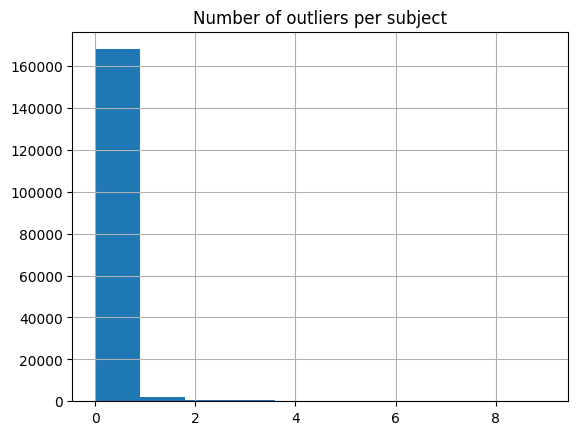

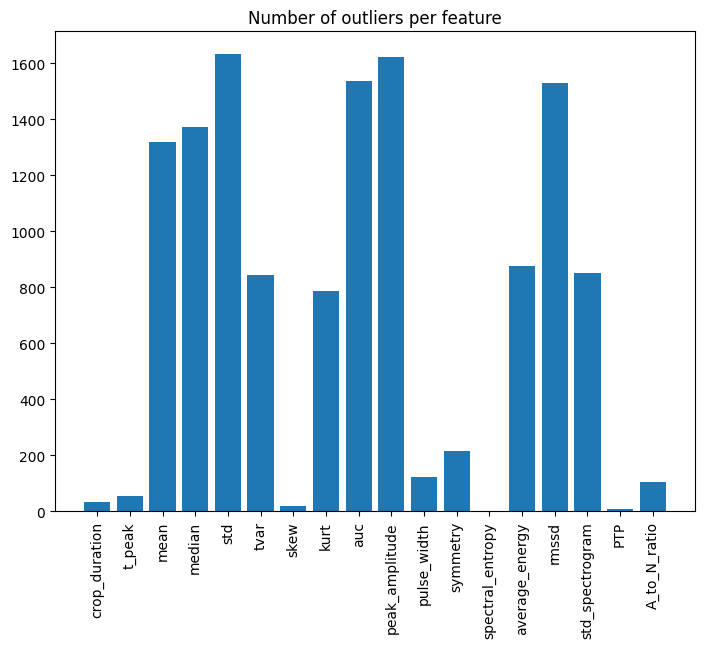

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


Outliers detected (validation): 11026
Missing values after outlier removal (validation): 11026
Number of patients dropped: 0


NameError: name 'svm' is not defined

In [169]:
#---------------------------------------------------
#               Feature scaling
#---------------------------------------------------

train_features = train_df.copy()
validation_features = val_df.copy()
test_features = val_df.copy()

### ----------- Outlier removal --------------------

feature_list = train_features.columns
print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# apply zscore
scaler = StandardScaler().fit(train_features)
zscore_features = scaler.transform(train_features)

# select all those values with zscore > -+ 3  as outliers
abs_zscores = np.abs(zscore_features)

outliers_detected = abs_zscores > 3
print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# set outliers as missing values
train_features[outliers_detected] = np.nan
train_features =  pd.DataFrame(data=train_features, columns=feature_list)

print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))

abs_zscores =  pd.DataFrame(data=abs_zscores, columns=feature_list)
plot_outliersAnalysis(abs_zscores, feature_list)
display(train_features)

# Apply to validation set
zscore_features = scaler.transform(validation_features)
abs_zscores = np.abs(zscore_features)
outliers_detected = abs_zscores > 3
print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))


validation_features[outliers_detected] = np.nan
validation_features =  pd.DataFrame(data=validation_features, columns=feature_list)

print('Missing values after outlier removal (validation): ' + str(validation_features.isnull().sum().sum()))

### ---------- Missing data handling ---------------

# remove patients in training set with high percentage of missing data (TRAINING)
n_patiens_before = np.shape(train_features)[0]
train_features = train_features.dropna(thresh=np.shape(train_features)[1]/3)
n_patiens_after = np.shape(train_features)[0]
print('Number of patients dropped: ' + str(n_patiens_before-n_patiens_after))

# missing data imputation
# substitute by median
train_features_nan_median = train_features.fillna(train_features.median(axis=0))
validation_features_nan_median = validation_features.fillna(train_features.median(axis=0))

# Regression: KNN imputation
from sklearn.impute import KNNImputer
# define imputer
imputer = KNNImputer(n_neighbors=5 , weights='uniform', metric='nan_euclidean') #################################
# fit on the dataset
imputer.fit(train_features)

feature_list = train_features.columns

train_features_KNN = imputer.transform(train_features)
train_features_KNN =  pd.DataFrame(data=train_features_KNN, columns=feature_list)

validation_features_KNN = imputer.transform(validation_features)
validation_features_KNN =  pd.DataFrame(data=validation_features_KNN, columns=feature_list)

# testModel(train_features_KNN, train_labels, validation_features_KNN, validation_labels)

### ---------- Data standardization ----------------
# Standarize data with z-score transformation
from sklearn.preprocessing import StandardScaler

train_features_zscore = train_features_KNN
validation_features_zscore = validation_features_KNN

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)

display(train_features_zscore)

testModel(train_features_zscore, train_labels, validation_features_zscore, validation_labels)

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

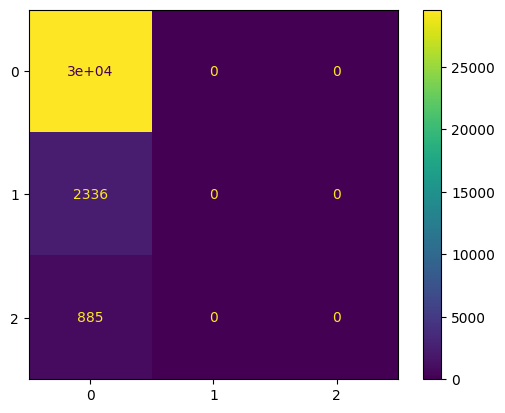

In [171]:
testModel(train_features_KNN, train_labels, validation_features_KNN, validation_labels)

### ---------- Data standardization ----------------
# Standarize data with z-score transformation
from sklearn.preprocessing import StandardScaler

train_features_zscore = train_features_KNN
validation_features_zscore = validation_features_KNN

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)

display(train_features_zscore)

testModel(train_features_zscore, train_labels, validation_features_zscore, validation_labels)

In [ ]:
# 3. Recurrent feature elimination with crossvalidation
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
min_features_to_select = 1 ###################################################################

rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(3), ###################################################
              scoring='balanced_accuracy',
              min_features_to_select=min_features_to_select)

rfecv.fit(train_features, train_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# adapt train & validation set
train_features = train_features.iloc[:, rfecv.support_]
validation_features = validation_features[train_features.columns]

fs_results_2 = pd.DataFrame({'ranking': rfecv.ranking_, 'selected': rfecv.support_},
                              index = [rfecv.feature_names_in_])
display(fs_results_2)

fs_results_1 = pd.DataFrame(rfecv.cv_results_)
display(fs_results_1)

# Plot number of features VS. cross-validation scores
plot_recurrentFE(min_features_to_select, rfecv)

In [139]:
# class FeatureConstructor:
#     def __init__(self, data_name=None):
#         """
#         :param
#             --data_name: filename like 'S001_128.mat' or tuple (data_path,label_path,peaks_path)
#         """
#         # Initialize class arguments
#         self.data_name = data_name

#         # Get information for patient with data_name
#         self.signal = OneSignal(data_name=self.data_name)
#         # Filter the PPG signal
#         self.signal.filter(fL = 0.5, fH = 4.3, order = 4)
#         # Align onsets to determine crops: always 1 peak between 2 onsets
#         self.signal.align_onsets()

#         # Set attributes of FeatureExtractor
#         self.ppg = self.signal.ppg              # get filtered ppg and derivatives
#         self.vpg = self.signal.vpg
#         self.apg = self.signal.apg
#         self.jpg = self.signal.jpg
#         self.fs = self.signal.fs                # sampling frequency                        --> int
#         self.peaks = self.signal.peaks.flatten()# peaks array                               --> (number_of_peaks,)
#         self.labels = self.signal.labels        # labels                                    --> (number_of_peaks,)
#         self.onsets = self.signal.on            # determined by self.signal.align_onsets()  --> (number_of_peaks+1,)


#     def generate_crops(self):
#         self.crops = []
#         while self.signal.indx < self.signal.indx_max:
#             # (x, y), (x_r, y_r) = self.signal.crop(raw=True)
#             crop, _ = self.signal.crop(raw=False)
#             self.crops.append(crop)

#     def get_intra_crop_features(self):
#         ""
#         self.ft_intra_crop_names = ['crop_duration','t_peak','mean','median','std','tvar','skew','kurt',
#                                     'auc','peak_amplitude','pulse_width','symmetry']
#         self.ft_intra_crop = np.zeros(((self.peaks.shape[0]), len(self.ft_intra_crop_names)))

#         # Construct self.crops
#         self.generate_crops()

#         # Loop over all crops: extract features
#         for i, crop in enumerate(self.crops):
#             self.ft_intra_crop[i,:] = np.array(
#                 [crop.shape[0] / self.fs,
#                  np.argmax(crop) / self.fs,
#                  np.mean(crop),
#                  np.median(crop),
#                  np.std(crop),
#                  tvar(crop), # tune values?
#                  skew(crop),
#                  kurtosis(crop),
#                  simps(np.abs(crop), dx=1/self.fs), # AUC: Simpson's rule for numeral integration
#                  np.max(crop)-np.min(crop),
#                  self.pulse_width(crop),
#                  self.symmetry_index(crop)
#                  ])

#     def get_inter_crop_features(self):
#         ""
#         self.ft_inter_crop_names = ['PTP','N_last_X_s']

#         self.ft_inter_crop = np.zeros(((self.peaks.shape[0]), len(self.ft_inter_crop_names)))
        
#         self.ft_inter_crop[:,0] = self.peak_to_peak_times()
#         self.ft_inter_crop[:,1] = self.N_ratio()

#     def get_patient_specific_features(self):
#         ""
#         self.ft_patient_names = ['name']
#         self.ft_patient = np.zeros(((self.peaks.shape[0]), len(self.ft_patient_names)))
        
#         self.ft_patient[:,0] = self.data_name.split('_')[0][1:]



#     def construct_dataframe(self, out_file=''):
#         # Get features
#         self.feature_names = self.ft_intra_crop_names + self.ft_inter_crop_names + self.ft_patient_names
#         features = np.concatenate([self.ft_intra_crop, self.ft_inter_crop, self.ft_patient], axis=-1)

#         # Create a DataFrame
#         data = {'peaks': self.peaks, 'labels': self.labels}
#         for i, feature_name in enumerate(self.feature_names):
#             data[feature_name] = features[:, i]

#         self.df = pd.DataFrame(data)

#         # Save DataFrame to .csv file
#         current_directory = os.path.dirname(os.path.abspath('__file__'))
#         folder_name = 'dataset/ML_features/'
#         target_folder = os.path.join(current_directory, folder_name)

#         ## Check if the folder exists and create it if not
#         if not os.path.exists(target_folder):
#             os.makedirs(target_folder)

#         file_path = os.path.join(target_folder, self.data_name.split('.')[0] + '.csv')
#         self.df.to_csv(file_path, index=False)

#     #---------------------------------------------------
#     #   Functions used in get_intra_crop_features()
#     #---------------------------------------------------
        
#     def pulse_width(self, crop):
#         if len(crop) == 0:
#             return 0  # or some default value, as appropriate
        
#         half_peak = max(crop) / 2
#         idx_peak = np.argmax(crop)
        
#         # Find indices on both sides of the peak
#         # Index of half value of peak before peak
#         idx_t1 = self.find_nearest(crop[:idx_peak], half_peak)
#         # Index of half value of peak after peak
#         idx_t2 = self.find_nearest(crop[idx_peak:], half_peak) + idx_peak

#         # Calculate the width
#         width = (idx_t2 - idx_t1)/self.fs # [s]

#         return width

#     #From https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
#     def find_nearest(self, array, value):
#         array = np.asarray(array)
#         if len(array) == 0:
#             idx = 0
#         else:
#             idx = (np.abs(array - value)).argmin()
#         return idx
    
#     def symmetry_index(self, crop):
#         middle_idx = len(crop) // 2
        
#         left_half = crop[:middle_idx]
#         right_half = crop[middle_idx:]
        
#         mean_left = np.mean(left_half)
#         mean_right = np.mean(right_half)

#         symmetry_index = mean_right / mean_left
        
#         return symmetry_index
    
#     #---------------------------------------------------
#     #   Functions used in get_inter_crop_features()
#     #---------------------------------------------------

#     def peak_to_peak_times(self):
#         time_between_peaks = np.diff(self.peaks) / self.fs
#         mean_PTP = np.mean(time_between_peaks)
#         time_between_peaks = mean_PTP
#         time_between_peaks = np.insert(time_between_peaks, 0, mean_PTP)

#         return time_between_peaks
    
#     def N_ratio(self, time_window=20):
#         indices_before = int(time_window*self.fs)

#         number_of_Ns = np.zeros(len(self.peaks))
#         for i, peak_idx in enumerate(self.peaks):
#             indices_in_window = np.where((peak_idx - indices_before <= self.peaks) & (self.peaks < peak_idx))[0]
#             count = np.count_nonzero(self.labels[indices_in_window] ==  'N')
#             number_of_Ns[i] = count

#         return number_of_Ns
        
#     # def drop_empty_crops(self, crops):

#     #     out = [crop for crop in crops if len(crop) > 4]
#     #     print("Number of crops eliminated: ", len(crops)-len(out))
#     #     return out

#     # def get_max_freq(self, crop, fs): #NEED FS OF INDIVIDUAL SIGNAL :(
#     #     fft = np.fft.fft(crop)
#     #     freqs = np.fft.fftfreq(len(crop), d=1/fs)
#     #     dom_freq_idx = np.argmax(np.abs(fft))
#     #     dom_freq = np.abs(freqs[dom_freq_idx])
#     #     return dom_freq

# current_directory = os.path.dirname(os.path.abspath('__file__'))
# folder_name = 'dataset/data/'
# target_folder = os.path.join(current_directory, folder_name)

# for file_name in tqdm(os.listdir(target_folder)[:2]):
#     print(file_name)
#     recording = FeatureConstructor('S001_128.mat')
#     recording.get_intra_crop_features()
#     recording.get_inter_crop_features()
#     recording.get_patient_specific_features()
#     recording.construct_dataframe()

# # 107/120

In [141]:
df['peak_amplitude']

0         3.111276
1         2.626051
2         2.832734
3         2.631315
4         1.944462
            ...   
244128    4.014716
244129    3.708280
244130    3.530775
244131    3.223087
244132    2.646441
Name: peak_amplitude, Length: 244133, dtype: float64

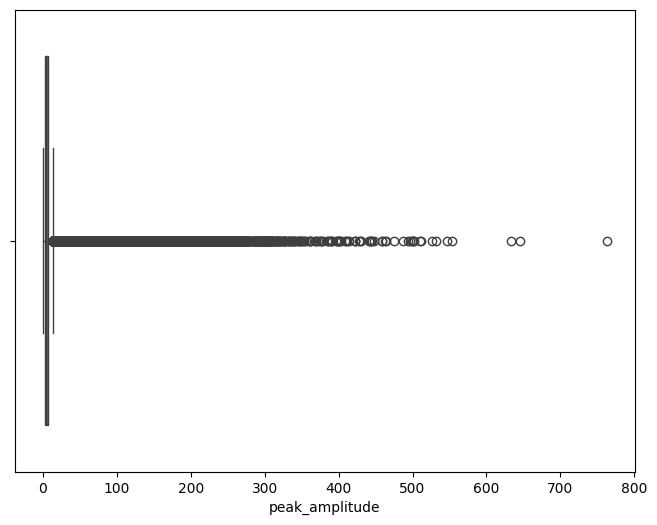

In [142]:
# Create a boxplot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='peak_amplitude', data=df)

# Show the plot
plt.show()

# Load in features & normalize

In [143]:
df

,peaks,labels,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,...,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio,name
0,83,N,1.031250,0.632812,-0.074814,-0.345831,0.880778,0.781693,0.695468,-0.694012,...,3.111276,0.210938,-0.715613,1.103237,0.012297,0.062113,0.068949,0.690797,0.0,1.0
1,165,N,0.640625,0.250000,-0.074206,-0.091540,0.849451,0.730475,0.012791,-1.337709,...,2.626051,0.179688,-2.350049,0.993750,0.009069,0.070542,0.046523,0.640625,0.0,1.0
2,247,N,0.640625,0.250000,0.007296,-0.030241,0.917613,0.852409,0.042105,-1.364003,...,2.832734,0.187500,-0.954381,0.974546,0.010833,0.074184,0.058178,0.640625,0.0,1.0
3,330,N,0.562500,0.265625,0.064259,0.110945,0.824823,0.689915,-0.265204,-1.122555,...,2.631315,0.187500,-2.598195,0.968880,0.008414,0.071950,0.039970,0.648438,0.0,1.0
4,394,S,0.679688,0.234375,-0.119052,-0.184392,0.574101,0.333425,0.047393,-1.105410,...,1.944462,0.171875,-2.065566,0.966895,0.004433,0.043567,0.025463,0.500000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,449149,N,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,...,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.0,121.0
244129,449324,N,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,...,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.0,121.0
244130,449511,N,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,...,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.0,121.0
244131,449703,N,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,...,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.0,121.0


In [144]:
from sklearn.model_selection import train_test_split

# Generate a list of numbers from 1 to 121 (excluding 107 and 120)
patient_numbers = [i for i in range(1, 122) if i not in [107, 120]+list(range(63, 79))]
print(len(patient_numbers))

# Set random state: reproducibility
random_state(36)

# Split the data into training (70%), validation (15%), and test (15%) sets
train_numbers, non_train_numbers = train_test_split(patient_numbers, test_size=0.3, random_state=36)
val_numbers, test_numbers = train_test_split(non_train_numbers, test_size=0.5, random_state=36)

# Print the lengths of the sets
print(f"Training set size: {len(train_numbers)}")
print(f"Validation set size: {len(val_numbers)}")
print(f"Test set size: {len(test_numbers)}")

# 2. Perform train-test stratified split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random

# Select rows where the 'ID' column is in the predetermined list
train_df = df[df['name'].isin(train_numbers)]
val_df = df[df['name'].isin(val_numbers)]
test_df = df[df['name'].isin(test_numbers)]

# Drop "useless" features
train_df = train_df.drop(columns=['peaks', 'labels', 'name'])
val_df = val_df.drop(columns=['peaks', 'labels', 'name'])
test_df = test_df.drop(columns=['peaks', 'labels', 'name'])

103
Training set size: 72
Validation set size: 15
Test set size: 16


In [145]:
# features = df.drop(columns=['peaks', 'labels'])
# labels = df.labels




# train_full, test = train_test_split(features, test_size=0.2, shuffle=True,
#                                     stratify=labels)

# labels = train_full.label

# train, validation = train_test_split(train_full, test_size=0.25,
#                                      shuffle=True, stratify=labels)

# train_labels = train.label
# train_features = train.drop(columns='label')

# validation_labels = validation.label
# validation_features = validation.drop(columns='label')

# test_labels = test.label
# test_features = test.drop(columns='label')


# 1. Perform z-scoring for outlier removal
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# feature_list = train_features.columns
# print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# # apply zscore
# scaler = StandardScaler().fit(features)
# zscore_features = scaler.transform(features)

# # select all those values with zscore > -+ 3  as outliers
# abs_zscores = np.abs(zscore_features)

# outliers_detected = abs_zscores > 3
# print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# # set outliers as missing values
# train_features[outliers_detected] = np.nan
# train_features =  pd.DataFrame(data=train_features, columns=feature_list)

# print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))


# abs_zscores =  pd.DataFrame(data=abs_zscores, columns=feature_list)
# plot_outliersAnalysis(abs_zscores)
# display(train_features)

In [146]:
train_df

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [147]:
val_df.peak_amplitude.max(), test_df.peak_amplitude.max()

(632.9872864322915, 645.1175084372959)

In [148]:
train_df.crop_duration.max(), val_df.crop_duration.max(), test_df.crop_duration.max()

(54.82, 3.0703125, 2.671875)

Missing values before outlier removal: 0
Outliers detected (train): 222921


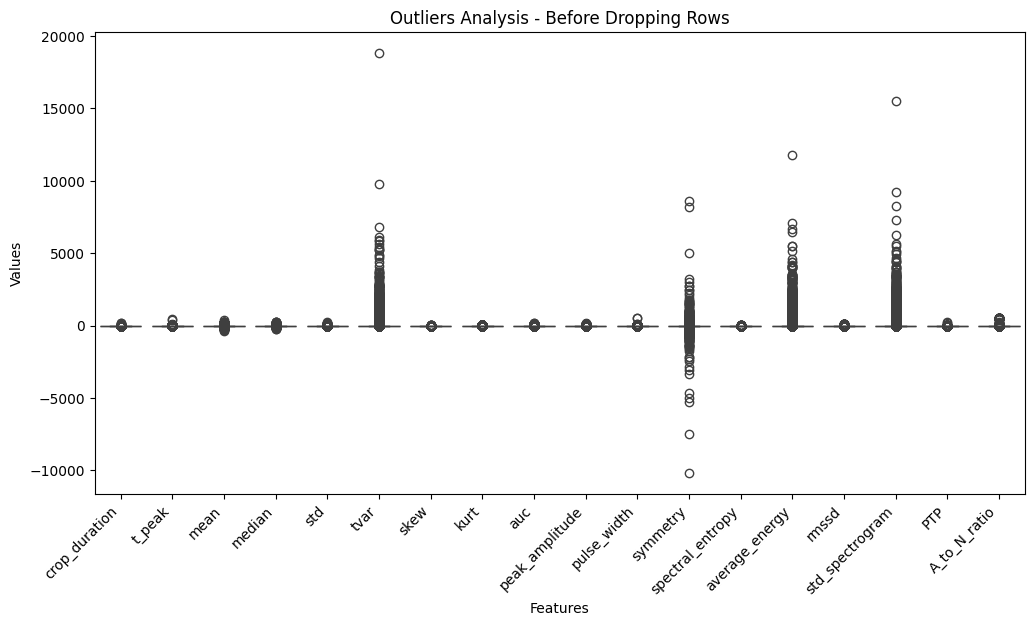

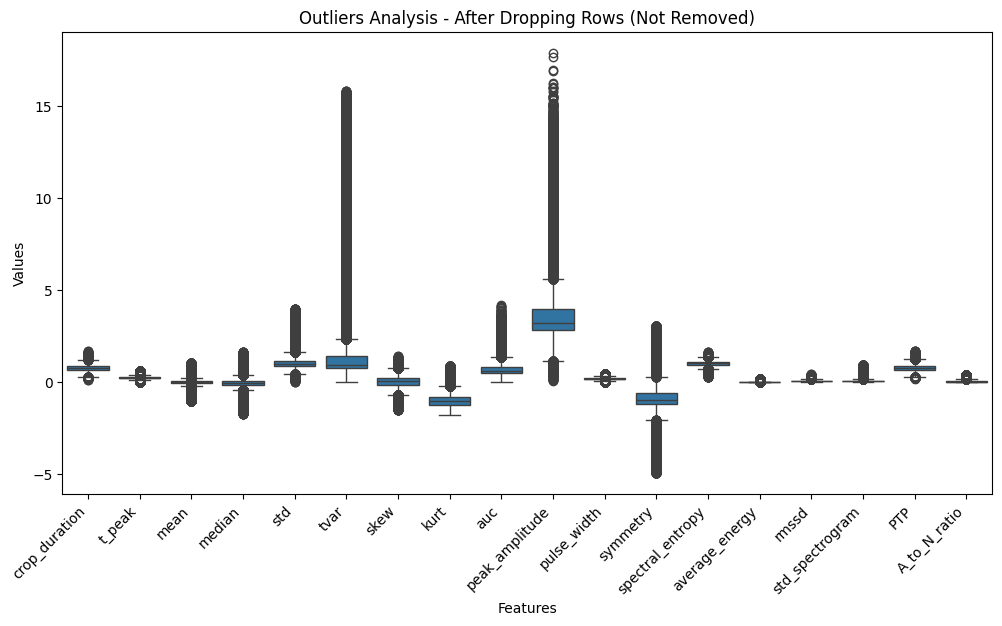

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
2610,0.679688,0.164062,-0.791932,-0.639962,2.427639,5.961962,-0.186041,-0.894471,1.390153,8.235904,0.140625,-3.126324,1.034560,0.105222,0.245969,0.500076,0.773438,0.166667
2611,0.570312,0.250000,0.925689,0.920316,2.572535,6.709851,-0.098208,-1.383105,1.337349,7.792363,0.226562,0.105581,0.938195,0.089522,0.215647,0.457790,0.773438,0.142857
2623,0.843750,0.289062,0.799597,1.050940,1.453837,2.133395,-0.083081,-1.115024,1.192889,4.665827,0.250000,0.329010,1.110983,0.025115,0.105094,0.131491,0.773438,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [154]:
def plot_outliers_analysis(data, feature_list, title):
    # Function to plot outliers analysis
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="variable", y="value", data=pd.melt(data))
    plt.title(f'Outliers Analysis - {title}')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.xticks(rotation=45, ha='right')
    plt.show()


train_features = train_df.copy()

feature_list = train_features.columns
print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# apply RobustScaler
scaler = RobustScaler().fit(train_features)
robust_scaled_features = scaler.transform(train_features)

# select all those values with absolute value > 3 as outliers
outliers_detected = np.abs(robust_scaled_features) > 4
print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# set outliers as missing values
train_features[outliers_detected] = np.nan
# Drop rows containing NaN values
train_features = train_features.dropna()

# Plot outliers analysis before dropping rows
robust_scaled_features_before_drop = pd.DataFrame(data=robust_scaled_features, columns=feature_list)
plot_outliers_analysis(robust_scaled_features_before_drop, feature_list, "Before Dropping Rows")
# Plot outliers analysis after dropping rows without actually dropping them
plot_outliers_analysis(train_features, feature_list, "After Dropping Rows (Not Removed)")
# # Display the resulting DataFrame
# display(train_features)

In [130]:
train_df

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,1.000000
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,1.000000
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000


In [ ]:
# 2. Standarize data with z-score transformation
from sklearn.preprocessing import StandardScaler

train_features_zscore = train_features_KNN
validation_features_zscore = validation_features_KNN

transformer = StandardScaler().fit(train_features_zscore)
train_features_zscore = transformer.transform(train_features_zscore)
train_features_zscore = pd.DataFrame(data=train_features_zscore, columns=feature_list)

# adapt validation set
validation_features_zscore = transformer.transform(validation_features_zscore)
validation_features_zscore = pd.DataFrame(data=validation_features_zscore, columns=feature_list)

display(train_features_zscore)

In [83]:
"Given functions"
def plot_outliersAnalysis(abs_zscores, feature_list):
  # number of outliers per subject
  bool_zscores = (abs_zscores > 5).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature
  bool_zscores = (abs_zscores > 5).sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])

  ax.bar(feature_list,bool_zscores)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list)), feature_list,rotation=90)
  plt.show()
  return

In [150]:
# # 1. Perform z-scoring for outlier removal
# from scipy.stats import zscore
# from sklearn.preprocessing import StandardScaler
# import numpy as np

# train_features = train_df
# validation_features = val_df

# feature_list = train_features.columns
# print('Missing values before outlier removal: ' + str(train_features.isnull().sum().sum()))

# # apply zscore
# scaler = StandardScaler().fit(train_features)
# zscore_features = scaler.transform(train_features)

# # select all those values with zscore > -+ 3  as outliers
# abs_zscores = np.abs(zscore_features)

# outliers_detected = abs_zscores > 2
# print('Outliers detected (train): ' + str(np.sum(np.sum(outliers_detected))))

# # set outliers as missing values
# train_features[outliers_detected] = np.nan
# train_features =  pd.DataFrame(data=train_features, columns=feature_list)

# print('Missing values after outlier removal (train): ' + str(train_features.isnull().sum().sum()))


# abs_zscores =  pd.DataFrame(data=abs_zscores, columns=feature_list)
# plot_outliersAnalysis(abs_zscores, feature_list)
# display(train_features)

# # Apply to validation set
# zscore_features = scaler.transform(validation_features)
# abs_zscores = np.abs(zscore_features)
# outliers_detected = abs_zscores > 3
# print('Outliers detected (validation): ' + str(np.sum(np.sum(outliers_detected))))


# validation_features[outliers_detected] = np.nan
# validation_features =  pd.DataFrame(data=validation_features, columns=feature_list)

# print('Missing values after outlier removal (validation): ' + str(validation_features.isnull().sum().sum()))

In [99]:
train_df

,crop_duration,t_peak,mean,median,std,tvar,skew,kurt,auc,peak_amplitude,pulse_width,symmetry,spectral_entropy,average_energy,rmssd,std_spectrogram,PTP,A_to_N_ratio
2603,1.187500,0.531250,-0.137542,-0.174041,0.610203,0.374813,0.327304,0.122749,0.573471,2.644502,0.179688,-4.521716,1.419786,0.004996,0.040979,0.026642,0.765439,0.000000
2604,0.835938,0.257812,0.191867,-0.028647,1.073234,1.162698,0.404985,-0.767363,0.676881,3.688874,0.195312,-0.441466,1.159771,0.014821,0.090450,0.071151,0.937500,NaN
2605,0.828125,0.648438,-0.134108,-0.108065,1.106474,1.235944,-0.168062,-1.320787,0.800139,3.399380,0.140625,0.090509,1.002858,0.020052,0.124543,0.112323,0.812500,NaN
2606,0.710938,0.195312,0.026860,0.115230,1.909596,3.687074,-0.486495,-0.337794,0.996920,7.030406,0.171875,-0.938495,1.080086,0.045897,0.145430,0.233011,0.796875,0.500000
2607,0.664062,0.375000,0.274432,0.500693,2.383523,5.748813,-0.367361,-1.096476,1.356800,7.457452,0.234375,-1.494914,0.924359,0.074953,0.156147,0.422145,0.804688,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244128,0.728000,0.256000,0.305786,0.607647,1.094490,1.204527,-0.734365,-0.270232,0.708380,4.014716,0.188000,1.178893,1.194078,0.006386,0.049120,0.035931,0.696000,0.000000
244129,0.720000,0.208000,-0.105226,-0.452086,1.028114,1.062923,0.216009,-0.807216,0.625204,3.708280,0.168000,-1.330612,1.008371,0.007419,0.042227,0.057636,0.700000,0.000000
244130,0.768000,0.244000,-0.042105,0.040649,0.939306,0.886916,-0.259986,-0.546747,0.544550,3.530775,0.164000,-1.526166,1.257259,0.004936,0.044077,0.028181,0.748000,0.000000
244131,0.600000,0.240000,0.347119,-0.043418,0.939167,0.887954,0.252589,-0.978847,0.455624,3.223087,0.176000,0.235690,1.044008,0.006288,0.047865,0.038924,0.768000,0.000000
